# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Load-CML-example-data" data-toc-modified-id="Load-CML-example-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load CML example data</a></div><div class="lev1 toc-item"><a href="#Do-a-simple-standard-processing-to-get-rain-rates-for-each-CML" data-toc-modified-id="Do-a-simple-standard-processing-to-get-rain-rates-for-each-CML-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Do a simple standard processing to get rain rates for each CML</a></div><div class="lev1 toc-item"><a href="#Do-IDW-interpolation-of-CML-rain-rates" data-toc-modified-id="Do-IDW-interpolation-of-CML-rain-rates-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Do IDW interpolation of CML rain rates</a></div><div class="lev2 toc-item"><a href="#Initialize-interpolator" data-toc-modified-id="Initialize-interpolator-31"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Initialize interpolator</a></div><div class="lev2 toc-item"><a href="#Perform-interpolation-for-all-time-steps" data-toc-modified-id="Perform-interpolation-for-all-time-steps-32"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Perform interpolation for all time steps</a></div>

In [1]:
%matplotlib inline

In [4]:
import pycomlink as pycml

import matplotlib.pyplot as plt
from tqdm import tqdm_notebook

# Load CML example data
Coordinates mimic the real network topology but are fake

In [13]:
cml_list = pycml.io.examples.read_cml_list()

75 CMLs read in


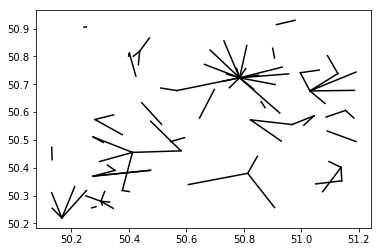

In [14]:
fig, ax = plt.subplots()
for cml in cml_list:
    cml.plot_line(ax=ax, color='k')

# Do a simple standard processing to get rain rates for each CML

In [15]:
for cml in tqdm_notebook(cml_list):
    window_length = 60
    threshold = 1.0
    cml.process.wet_dry.std_dev(window_length=window_length, threshold=threshold)
    cml.process.baseline.linear()
    cml.process.baseline.calc_A()
    cml.process.A_R.calc_R()

A Jupyter Widget

# Do IDW interpolation of CML rain rates

The `ComlinkGridInterpolator` takes a `PointsToGridInterpolator` object as argument, which is used for the interpolation of each time step. You can pass config arguments to the initialization of the `PointsToGridInterpolator`.

Currently only the IDW interpolator `IdWKdtreeInterpolator` which subclasses `PointsToGridInterpolator` is available. A Kriging version is already implemented but does not work reliably.

## Initialize interpolator 

`resolution` is used to generate a grid using a bounding box aroudn all CMLs if no x- and y-grid are supplied.

Currently CML rain rates are averaged to hourly data before interpolating.

In [16]:
cml_interp = pycml.spatial.interpolator.ComlinkGridInterpolator(
    cml_list=cml_list,
    resolution=0.01,
    interpolator=pycml.spatial.interpolator.IdwKdtreeInterpolator())

## Perform interpolation for all time steps 

In [17]:
zgrids = cml_interp.loop_over_time()

100%|██████████| 48/48 [00:00<00:00, 142.49it/s]


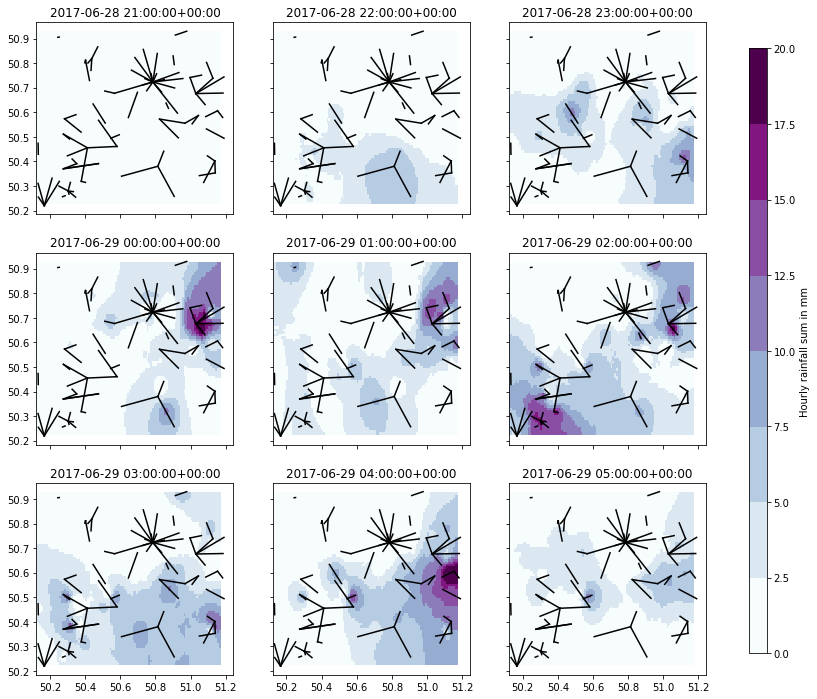

In [9]:
fig, ax = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(12,12))

for i, axi in enumerate(ax.flat):
    for cml in cml_list:
        cml.plot_line(ax=axi, color='k')
    
    pc = axi.pcolormesh(cml_interp.xgrid,
                        cml_interp.ygrid,
                        zgrids[20+i], 
                        cmap=plt.get_cmap('BuPu', 8), 
                        vmin=0,
                        vmax=20)
    axi.set_title(cml_interp.df_cmls.index[20+i])
    
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.95, 0.15, 0.02, 0.7])
fig.colorbar(pc, cax=cbar_ax, label='Hourly rainfall sum in mm');